In [1]:
import sys

sys.path.append("..")

In [2]:
from tensorflow import keras
from keras_tuner import HyperParameters

In [3]:
from utils.preprocessing_utils import PreprocessingUtils

In [4]:
from utils.model_wrapper import ModelWrapper

In [5]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Loading split data...
Split data loaded successfully!


In [6]:
def inception_module(x, filters: list[int]):
    tower_1 = keras.layers.Conv2D(
        filters[0], (1, 1), padding="same", activation="relu"
    )(x)
    tower_1 = keras.layers.Conv2D(
        filters[1], (3, 3), padding="same", activation="relu"
    )(tower_1)

    tower_2 = keras.layers.Conv2D(
        filters[2], (1, 1), padding="same", activation="relu"
    )(x)
    tower_2 = keras.layers.Conv2D(
        filters[3], (5, 5), padding="same", activation="relu"
    )(tower_2)

    tower_3 = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
    tower_3 = keras.layers.Conv2D(
        filters[4], (1, 1), padding="same", activation="relu"
    )(tower_3)

    tower_4 = keras.layers.Conv2D(
        filters[5], (1, 1), padding="same", activation="relu"
    )(x)

    concatenated = keras.layers.Concatenate(axis=-1)(
        [tower_1, tower_2, tower_3, tower_4]
    )
    return concatenated


def build_google_net(hp: HyperParameters):
    input_layer = keras.layers.Input(shape=preprocessing_utils.images.shape[1:])

    x = keras.layers.Conv2D(
        hp.Int("conv_1_filter", min_value=32, max_value=96, step=32),
        (7, 7),
        strides=(2, 2),
        padding="same",
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(input_layer)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Conv2D(
        hp.Int("conv_2_filter", min_value=32, max_value=96, step=32),
        (1, 1),
        padding="same",
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x)
    x = keras.layers.Conv2D(
        hp.Int("conv_3_filter", min_value=96, max_value=192, step=32),
        (3, 3),
        padding="same",
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_module(x, [64, 128, 32, 32, 32, 32])
    x = inception_module(x, [128, 192, 96, 64, 64, 64])

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(
        hp.Int("dense_1_units", min_value=128, max_value=512, step=128),
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x)
    x = keras.layers.Dropout(
        hp.Float("dropout_1_rate", min_value=0.25, max_value=0.5, step=0.25)
    )(x)

    output_layer = keras.layers.Dense(
        preprocessing_utils.num_classes, activation="softmax"
    )(x)

    model = keras.models.Model(
        name="GoogLeNet", inputs=input_layer, outputs=output_layer
    )

    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling="log"),  # type: ignore
            momentum=hp.Float("momentum", 0.5, 0.9, step=0.1),  # type: ignore
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [7]:
google_net_wrapper = ModelWrapper("GoogleNet", preprocessing_utils=preprocessing_utils)

In [8]:
google_net_wrapper.build_model(
    build_fn=build_google_net, model_name=google_net_wrapper.model_name
)

Removing previous random search results...
Initializing random search...
Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  4736        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 32)   0           ['conv2d[0][0]']                 
                 

In [9]:
google_net_wrapper.train_and_save_model_and_history(batch_size=32)

Trial 10 Complete [00h 02m 43s]
val_loss: 2.9524378776550293

Best val_loss So Far: 2.7061824798583984
Total elapsed time: 00h 33m 28s
INFO:tensorflow:Oracle triggered exit


Training final model...
Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  4736        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 32)  0           ['conv2d_15[0][0]']              
                                                                  

In [10]:
google_net_wrapper.load_model_and_history()

Loading model from "../../artifacts/checkpoints/checkpoint_GoogleNet.h5"...


Model loaded successfully!
Loading history from "../../artifacts/model_histories/history_GoogleNet"...
History loaded successfully!


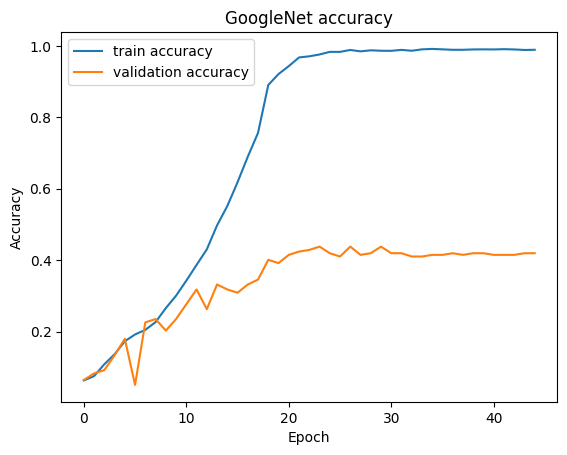

In [11]:
google_net_wrapper.plot_accuracy()

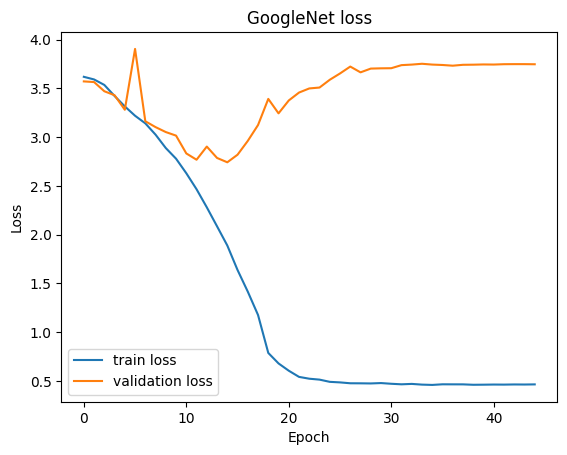

In [12]:
google_net_wrapper.plot_loss()

20/20 [==============================] - 1s 22ms/step - loss: 2.6125 - accuracy: 0.3764
Loss: 2.6125
Accuracy: 0.3764
20/20 [==============================] - 0s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.13      0.22        23
           1       0.33      0.20      0.25        25
           2       0.44      0.63      0.52        52
           3       0.24      0.32      0.27        38
           4       0.31      0.41      0.35        27
           5       0.36      0.26      0.30        35
           6       0.25      0.33      0.29        45
           7       0.00      0.00      0.00        10
           8       1.00      0.25      0.40        12
           9       0.50      0.18      0.27        11
          10       0.27      0.39      0.32        23
          11       0.59      0.38      0.47        26
          12       0.33      0.56      0.41        32
          13       0.33      0.33      0.33     

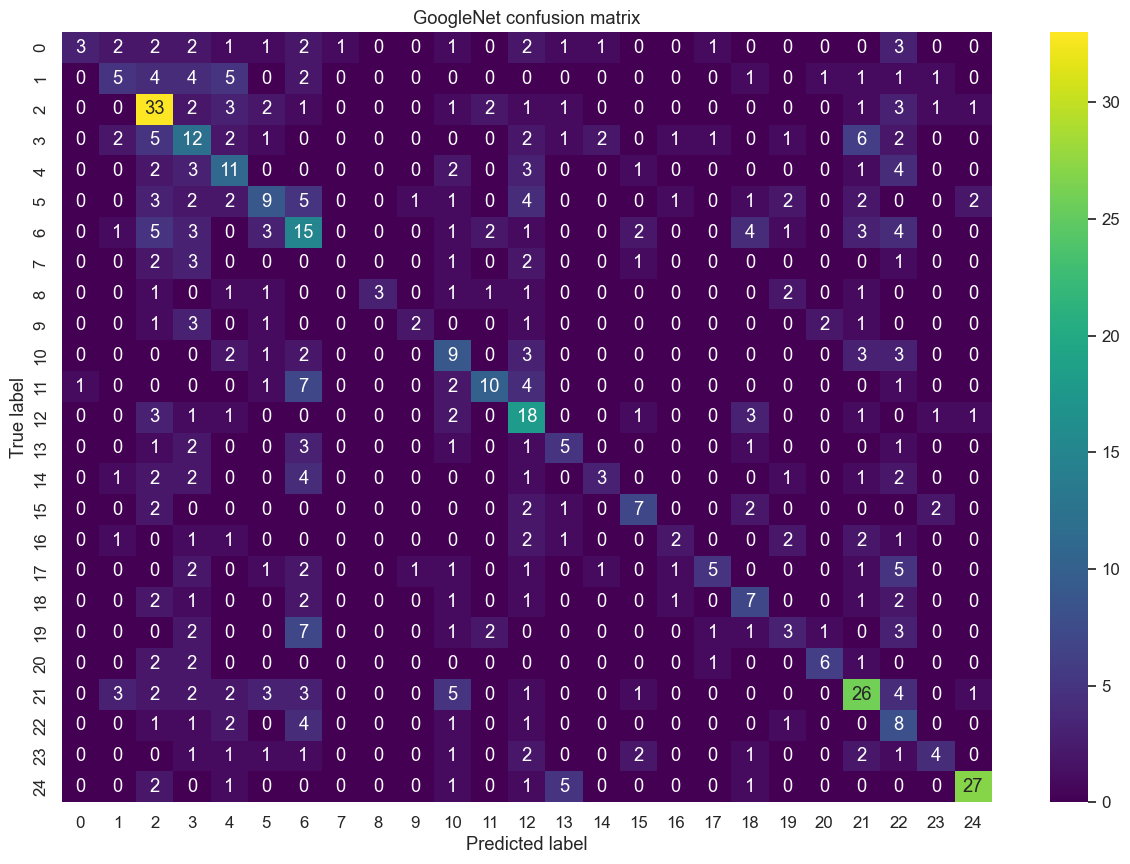

In [13]:
google_net_wrapper.display_evaluation_results()

In [15]:
!pip freeze > requirements.txt